In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [3]:
root = "/content/gdrive/MyDrive/COMP448/"
dataset = os.path.join(root, "Dataset")
os.chdir(root)

In [4]:
### imName also includes path info
def read_image(imName):
    im = cv.imread(imName)
    return np.flip(im, 2)

def write_image(im, imName):
    im = cv.imwrite(imName, cv.cvtColor(im, cv.COLOR_RGB2BGR))

In [5]:
def plot_image(im, w, h, cmap = "gray", title = False):
    fig = plt.figure(figsize = (w, h))
    plt.imshow(im, cmap = cmap, interpolation = "none")
    plt.xticks([])
    plt.yticks([])
    if title:
        plt.title(title)

In [6]:
def uint8_normalize(im):
    M = np.amax(im)
    m = np.amin(im)
    normalized = (255/(M - m))*(im - m)
    return normalized.round().astype(int)

In [7]:
def plot_segmentation(im, mask, w, h, show_type = "w"):
    imc = np.copy(im)
    if show_type == "w":
        fig = plt.figure(figsize = (w, h))
        imc[:,:,0][mask] = 255
        imc[:,:,1][mask] = 255
        imc[:,:,2][mask] = 255
        plt.imshow(imc, interpolation = "none")
        plt.xticks([])
        plt.yticks([])

In [16]:
"""
def eliminate_circular_components(mask, th = 0.3):
    labelnum, labels, stats, centroids = cv.connectedComponentsWithStats((1*mask).astype("uint8"))
    circularity = []
    sqrtpi = np.sqrt(np.pi)
    for c in range(1,labelnum):
        contours, hierarchy = cv.findContours((labels == c).astype("uint8"), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        perimeter = cv.arcLength(contours[0], closed = True)
        if perimeter == 0:
            perimeter = 2*sqrtpi
        circularity.append((4*np.pi*stats[c, 4])/(perimeter**2))
    circularity = np.array(circularity)
    circulars = 1 + np.nonzero(circularity >= th)[0]
    labels[np.isin(labels, circulars)] = 0
    return labels > 0
"""

In [21]:

def eliminate_circular_components(mask, th = 0.25):
  labelnum, labels, stats, centroids = cv.connectedComponentsWithStats(mask.astype("uint8"))
  circularity = []
  for c in range(1, labelnum):
    moms = cv.moments((labels == c).astype("uint8"), binaryImage = True)
    if moms["mu20"] + moms["mu02"] != 0:
      circularity.append((1/(2*np.pi))*(moms["m00"]**2)/(moms["mu20"] + moms["mu02"]))
    else:
      circularity.append(1)
  circularity = np.array(circularity)
  circulars = 1 + np.nonzero(circularity >= 0.25)[0]
  labels[np.isin(labels, circulars)] = 0
  return labels > 0


In [22]:
def fill_regions(im, mask):
    imc = np.copy(im)
    zeroed = np.copy(im)
    zeroed[mask] = [0,0,0]

    sums = cv.boxFilter(zeroed, cv.CV_32F, (11,11), normalize = False)
    num_values = cv.boxFilter(1*(zeroed > 0), cv.CV_32F, (11,11), normalize = False)


    if np.count_nonzero(num_values[:,:,0] == 0) > 0:
        troubled_indices = np.transpose(np.where(num_values[:,:,0] == 0))
        m = zeroed.shape[0]
        n = zeroed.shape[1]
        for i in range(troubled_indices.shape[0]):
            ksize = 6
            r, c = troubled_indices[i,0], troubled_indices[i, 1]
            while True:
                mr, Mr = max(r - ksize, 0), min(r + ksize + 1, m)
                mc, Mc = max(c - ksize, 0), min(c + ksize + 1, n)
                count = np.count_nonzero(zeroed[mr:Mr, mc:Mc,:]) / 3
                if count > 0:
                    zeroed[r, c] = np.sum(zeroed[mr:Mr, mc:Mc,:], (0,1)) / count
                    break
                else:
                    ksize += 1
        mask[troubled_indices[:,0], troubled_indices[:,1]] = 0
        num_values[troubled_indices[:,0], troubled_indices[:,1]] = 1

    avg = sums/num_values
    imc[mask] = avg[mask]
    return imc

In [23]:
def remove_hairs(im, size = 5, r = 2, plots = False):
    ksize = 2*size + 1

    in_filter = np.zeros((ksize, ksize))
    for i in range(ksize):
        for j in range(ksize):
            if (i - size)**2 + (j - size)**2 <= r**2:
                in_filter[i, j] = 1
    out_filter = 1 - in_filter

    in_filter = in_filter / np.sum(in_filter)
    out_filter = out_filter / np.sum(out_filter)

    #gray = im[:,:,2]
    gray = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
    smooth_gray = cv.GaussianBlur(gray, ksize = (3,3), sigmaX = 1)

    in_filt = cv.filter2D(smooth_gray, cv.CV_32F, in_filter)
    out_filt = cv.filter2D(smooth_gray, cv.CV_32F, out_filter)
    diff = out_filt - in_filt

    diff = uint8_normalize(diff)


    if plots:
        plot_image(diff, 7, 7, title = "Step 1")

    mean = np.mean(diff)
    std = np.std(diff)
    mask = ((diff - mean) > std)

    if plots:
        plot_image(mask.astype("uint8"), 7, 7, title = "Step 2")


    mask2 = eliminate_circular_components(mask, 0.2)

    if plots:
        plot_image(mask2.astype("uint8"), 7, 7, title = "Step 3")

    removed = fill_regions(im, mask2)

    if plots:
        plot_image(removed, 7, 7, title = "Result")

    return removed



In [11]:
def process_images(input_path, output_path):
  os.mkdir(output_path)
  ims = os.listdir(input_path)
  n = len(ims)
  checkpoint = 0
  for i in range(n):
    if (10*i)//n > checkpoint:
      print(f"%{10*(checkpoint + 1)} of images are processed.")
      checkpoint += 1
    image = read_image(os.path.join(input_path, ims[i]))
    processed = remove_hairs(image, plots = False)
    write_image(processed, os.path.join(output_path, ims[i]))

In [31]:
im = read_image(os.path.join(dataset, "unprocessed_dataset", "ISIC_0029287.jpg"))

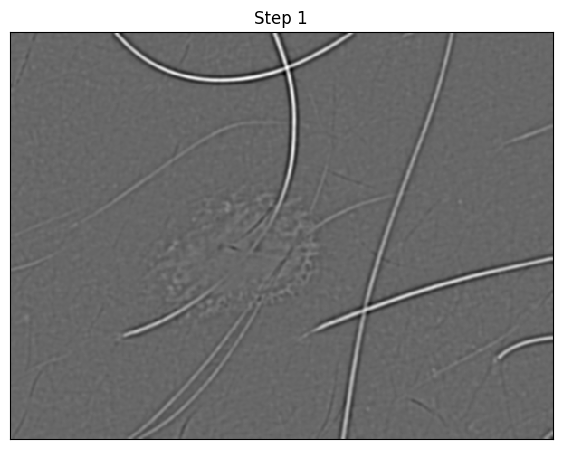

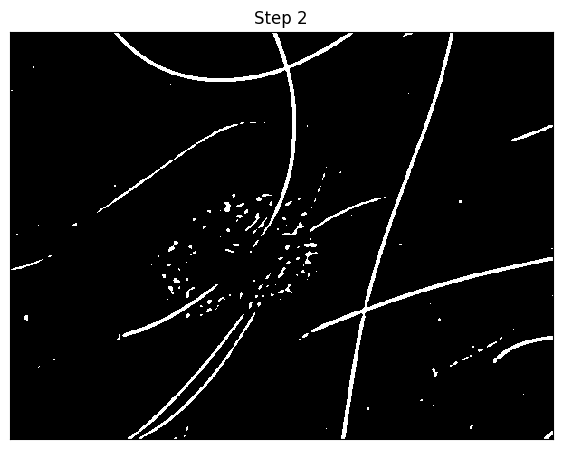

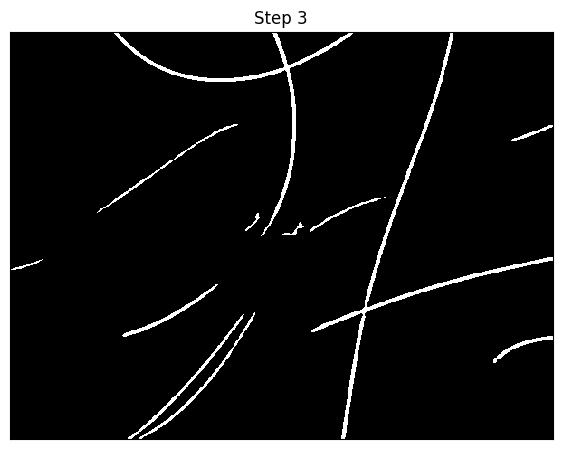

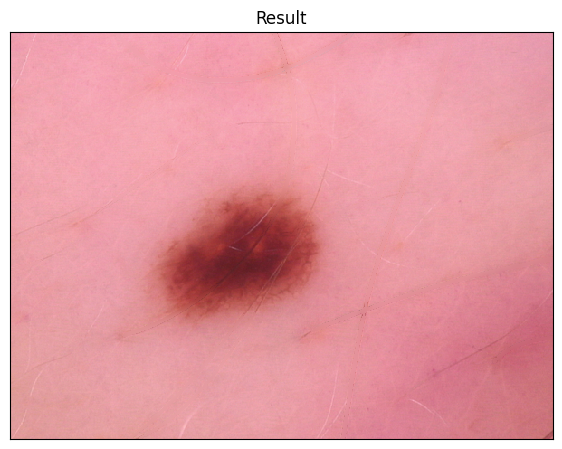

In [32]:
processed = remove_hairs(im, plots = True)

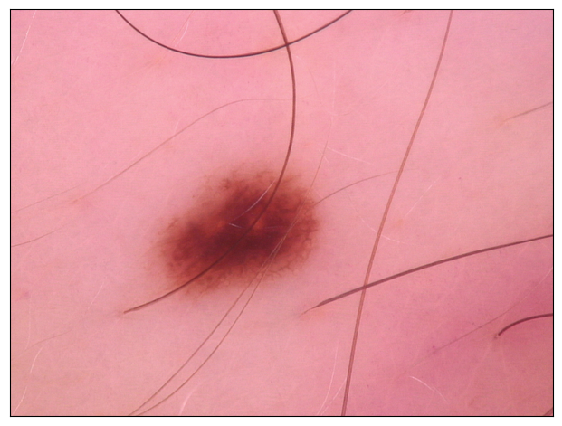

In [33]:
plot_image(im, 7, 7)

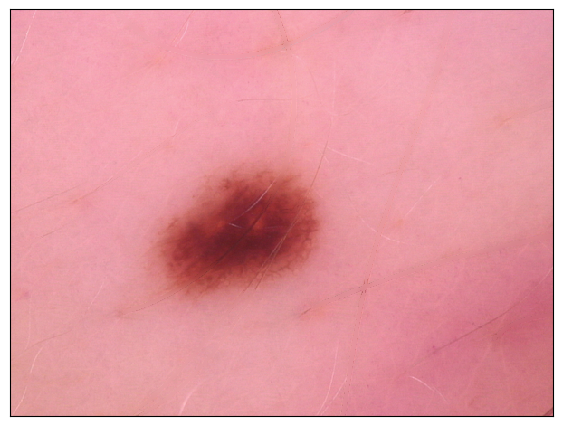

In [34]:
plot_image(processed, 7, 7)

In [ ]:
process_images(os.path.join(dataset, "unprocessed_dataset"), os.path.join(dataset, "processed_dataset_3"))

%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
%80 of images are processed.
%90 of images are processed.


In [ ]:
classes = os.listdir(os.path.join(dataset, "Validation"))
os.mkdir(os.path.join(dataset, "Validation_p1"))
for c in classes:
  print(f"Processing Validation/{c} images")
  process_images(os.path.join(dataset, "Validation", c), os.path.join(dataset, "Validation_p1", c))

Processing Validation/AKIEC images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
Processing Validation/BCC images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
%80 of images are processed.
%90 of images are processed.
Processing Validation/BKL images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
%80 of images are processed.
%90 of images are processed.


<ipython-input-15-c000ae99680e>:29: RuntimeWarning: invalid value encountered in divide
  avg = sums/num_values


Processing Validation/DF images
Processing Validation/MEL images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
%80 of images are processed.
%90 of images are processed.
Processing Validation/NV images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
%80 of images are processed.
%90 of images are processed.
Processing Validation/VASC images
%10 of images are processed.
%20 of images are processed.
